## Mask R-CNN - `Detect()` routine 

We generate the inputs to `DetectTargetLayer` , to manipulate and modify the layer to procduce a modified `output_rois` 
containing false positives. 
This will be passed on the the heatmap layer, and through there will become the input to FCN.

In [36]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys,os, pprint
pp = pprint.PrettyPrinter(indent=2, width=100)
print('Current working dir: ', os.getcwd())
if '..' not in sys.path:
    print("appending '..' to sys.path")
    sys.path.append('..')
    
import numpy as np
import mrcnn.utils     as utils
import mrcnn.visualize as visualize

from mrcnn.prep_notebook import  build_mrcnn_inference_pipeline, run_mrcnn_inference_pipeline,run_mrcnn_detection
from mrcnn.visualize     import display_training_batch
from mrcnn.prep_notebook import get_inference_batch, get_image_batch, get_training_batch
from mrcnn.coco          import prep_coco_dataset
from mrcnn.datagen import data_gen_simulate

input_parms  =" --batch_size     1  "
input_parms +=" --lr 0.00001     --val_steps 8 " 
input_parms +=" --mrcnn_logs_dir train_mrcnn_coco "
input_parms +=" --fcn_logs_dir   train_fcn8_subset " 
input_parms +=" --mrcnn_model    last "
input_parms +=" --coco_classes   78 79 80 81 82 44 46 47 48 49 50 51 34 35 36 37 38 39 40 41 42 43 10 11 13 14 15 "
input_parms +=" --sysout         screen "
# input_parms = " --epochs         2   --steps_in_epoch 32  --last_epoch 0 "
# input_parms +=" --fcn_model      init "
# input_parms +=" --opt            adam "
# input_parms +=" --fcn_arch       fcn8 " 
# input_parms +=" --fcn_layers     all " 
# input_parms +=" --coco_classes   62 63 67 78 79 80 81 82 72 73 74 75 76 77"
# input_parms +=" --new_log_folder    "
parser = utils.command_line_parser()
args = parser.parse_args(input_parms.split())
print(args)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Current working dir:  E:\git_projs\MRCNN3\notebooks
Namespace(batch_size='1', coco_classes=[78, 79, 80, 81, 82, 44, 46, 47, 48, 49, 50, 51, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 10, 11, 13, 14, 15], epochs=1, fcn_arch='FCN32', fcn_layers='fcn32+', fcn_logs_dir='train_fcn8_subset', fcn_model='last', last_epoch=0, lr='0.00001', mrcnn_exclude_layers=None, mrcnn_logs_dir='train_mrcnn_coco', mrcnn_model='last', new_log_folder=False, opt='ADAGRAD', scale_factor=4, steps_in_epoch=1, sysout='SCREEN', val_steps='8')


In [39]:
mrcnn_model = build_mrcnn_inference_pipeline(args = args, verbose = 0)


--> Execution started at: 12-02-2018 @ 18:55:15
    Tensorflow Version: 1.8.0   Keras Version : 2.2.0 
    MRCNN Model        :  last
    FCN Model          :  last
    MRCNN Log Dir      :  train_mrcnn_coco
    FCN Log Dir        :  train_fcn8_subset
    FCN Arch           :  FCN32
    FCN Training Layers:  fcn32+
    sysout             :  SCREEN
>>> Initialize Paths
 windows  Windows

Paths:
-------------------------
COCO_DATASET_PATH              F:\MLDatasets\coco2014
COCO_HEATMAP_PATH              F:\MLDatasets\coco2014_heatmaps
COCO_MODEL_PATH                F:\PretrainedModels\mask_rcnn_coco.h5
DIR_DATASET                    F:\MLDatasets
DIR_PRETRAINED                 F:\PretrainedModels
DIR_ROOT                       F:\
DIR_TRAINING                   F:\models
FCN_TRAINING_PATH              F:\models\train_fcn8_subset
FCN_VGG16_MODEL_PATH           F:\PretrainedModels\fcn_vgg16_weights_tf_dim_ordering_tf_kernels.h5
MRCNN_TRAINING_PATH            F:\models\train_mrcnn_coco
RE

In [40]:
# mrcnn_model.config.DETECTION_MAX_INSTANCES = 300
# mrcnn_model.config.DETECTION_MIN_CONFIDENCE = 0.1
mrcnn_model.config.display()


Configuration Parameters:
-------------------------
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COCO_CLASSES                   None
COCO_DATASET_PATH              F:\MLDatasets\coco2014
COCO_MODEL_PATH                F:\PretrainedModels\mask_rcnn_coco.h5
DETECTION_MAX_INSTANCES        200
DETECTION_MIN_CONFIDENCE       0.1
DETECTION_NMS_THRESHOLD        0.3
DETECTION_PER_CLASS            200
EPOCHS_TO_RUN                  0
FCN_INPUT_SHAPE                [1024 1024]
GPU_COUNT                      1
HEATMAP_SCALE_FACTOR           4
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LAST_EPOCH_RAN                 0
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  

## Load Training dataset

In [3]:
from mrcnn.coco          import prep_coco_dataset
##------------------------------------------------------------------------------------
## Build & Load Training and Validation datasets
## train  : 82081 |  train + val35k : 117266
## val    : 40137 | val35k : 35185 |  minival:  4952
## 
#   'accessory':   [27, 28, 31, 32, 33],          #   'animal':     [16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
#   'appliance':  [78, 79, 80, 81, 82],           #   'background': [0],
#   'electronic': [72, 73, 74, 75, 76, 77],       #   'food':       [52, 53, 54, 55, 56, 57, 58, 59, 60, 61],
#   'furniture':  [62, 63, 64, 65, 67, 70],       #   'indoor':     [84, 85, 86, 87, 88, 89, 90],
#   'kitchen':    [44, 46, 47, 48, 49, 50, 51],   #   'outdoor':    [10, 11, 13, 14, 15],
#   'person':     [1],                            #   'sports':     [34, 35, 36, 37, 38, 39, 40, 41, 42, 43],
#   'vehicle':    [2, 3, 4, 5, 6, 7, 8, 9]} 
# ------------------------------------------------------------------------------------
# load_class_ids = [62,63,64,65,67,70, 44,46,47,48,49,50,51,  72,73,74,75,76,77 , 82,61]
# load_class_ids = [62, 63, 67, 78, 79, 80, 81, 82, 72, 73, 74, 75, 76, 77]
load_class_ids = args.coco_classes
dataset_train, train_generator = prep_coco_dataset(["train", 'val35k'], mrcnn_model.config, generator = True, shuffle = False, return_coco =True, load_coco_classes=load_class_ids)
class_names = dataset_train.class_names 

COCO loading annotations file F:\MLDatasets\coco2014\annotations/instances_train2014.json  into memory...
Done (t=18.82s)
creating index...
index created!
 load subset of classes:  [78, 79, 80, 81, 82, 44, 46, 47, 48, 49, 50, 51, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 10, 11, 13, 14, 15]
 image dir            :  F:\MLDatasets\coco2014\train2014
 json_path_dir        :  F:\MLDatasets\coco2014\annotations/instances_train2014.json
 number of images     :  40400
 image_ids[:10]       :  [262146, 524291, 9, 393227, 393230, 131087, 393241, 393242, 131099, 393251]
 image_ids[1000:1010] :  [396150, 265080, 396157, 2951, 396172, 134032, 134033, 527250, 2963, 2964]
COCO loading annotations file F:\MLDatasets\coco2014\annotations/instances_valminusminival2014.json  into memory...
Done (t=8.17s)
creating index...
index created!
 load subset of classes:  [78, 79, 80, 81, 82, 44, 46, 47, 48, 49, 50, 51, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 10, 11, 13, 14, 15]
 image dir            :  F:\MLDatase

In [4]:
# pp.pprint(dataset_train.category_to_class_map)
# print()
# pp.pprint(dataset_train.category_to_external_class_map)
# print(' dataset_train.source_objs:   ',dataset_train.source_objs)
print('Len of dataset_train.image_info: ', len(dataset_train.image_info))
# print(dataset_train.image_info[0].keys())
# for i in range(10):
#     p = dataset_train.image_info[i]
#     print(i,p['id'], p['source'], p['path'])
print("Testing Dataset Image Count: {}".format(len(dataset_train.image_ids)))
print("Testing Dataset Class Count: {}".format(dataset_train.num_classes))
# pp.pprint(dataset_train.ext_to_int_id)
# pp.pprint(dataset_train.int_to_ext_id)
# for i, info in enumerate(dataset_test.class_info):
#     print("{:3}. {:50}".format(i, info['name']))
# pp.pprint(dataset_train.active_coco_class_ids)
# pp.pprint(dataset_train.active_class_ids) 

Len of dataset_train.image_info:  57457
Testing Dataset Image Count: 57457
Testing Dataset Class Count: 81


## Display Images

### Load using next(generator)

In [7]:
train_batch_x, _ = next(train_generator)

D:\Program Files\Anaconda3\envs\TF\lib\site-packages\scipy\ndimage\interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


 Image_id    :  1  Reference:  http://cocodataset.org/#explore?id=524291 Coco Id: 524291
 Image meta [   1  426  640    3  171    0  853 1024    1    1]
 Class ids   :  (4,)    [17 17  1 30]
 Class Names :  ['dog', 'dog', 'person', 'frisbee']


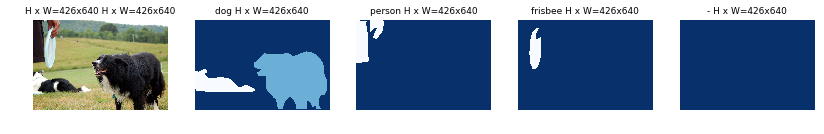

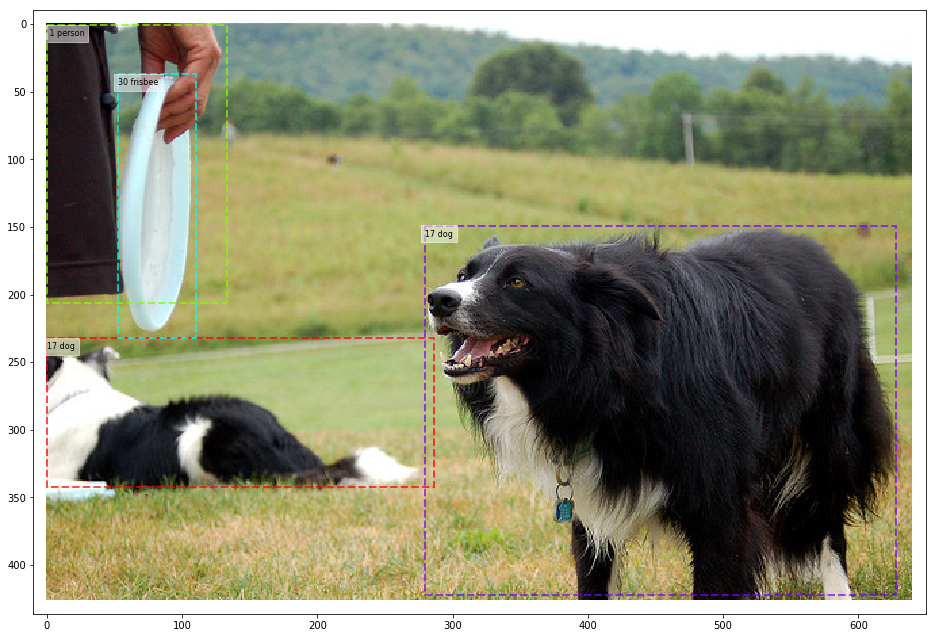


IMAGE_ID :  0
ext.id: 1 --> 1 - person 
ext.id: 35 --> 31 - skis 
ext.id: 27 --> 25 - backpack 


In [41]:
display_training_batch(dataset_train, train_batch_x)
dataset_train.display_annotation_info(0)

###  Display image with Ground Truth bounding boxes and masks

 batch size is : 1
 load image ud:  7
 Image_id    :  7  Reference:  http://cocodataset.org/#explore?id=393251 Coco Id: 393251
 Image meta [   7  640  480    3    0  128 1024  896    1    1]
 Class ids   :  (29,)    [57 57 41 41 41 44 56 61  1  1  1  1  1 42 44 57 57 57 57 61  1  1  1  1 57 61 61 44 57]
 Class Names :  ['chair', 'chair', 'wine glass', 'wine glass', 'wine glass', 'knife', 'cake', 'dining table', 'person', 'person', 'person', 'person', 'person', 'cup', 'knife', 'chair', 'chair', 'chair', 'chair', 'dining table', 'person', 'person', 'person', 'person', 'chair', 'dining table', 'dining table', 'knife', 'chair']


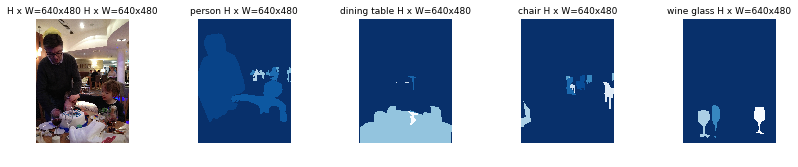

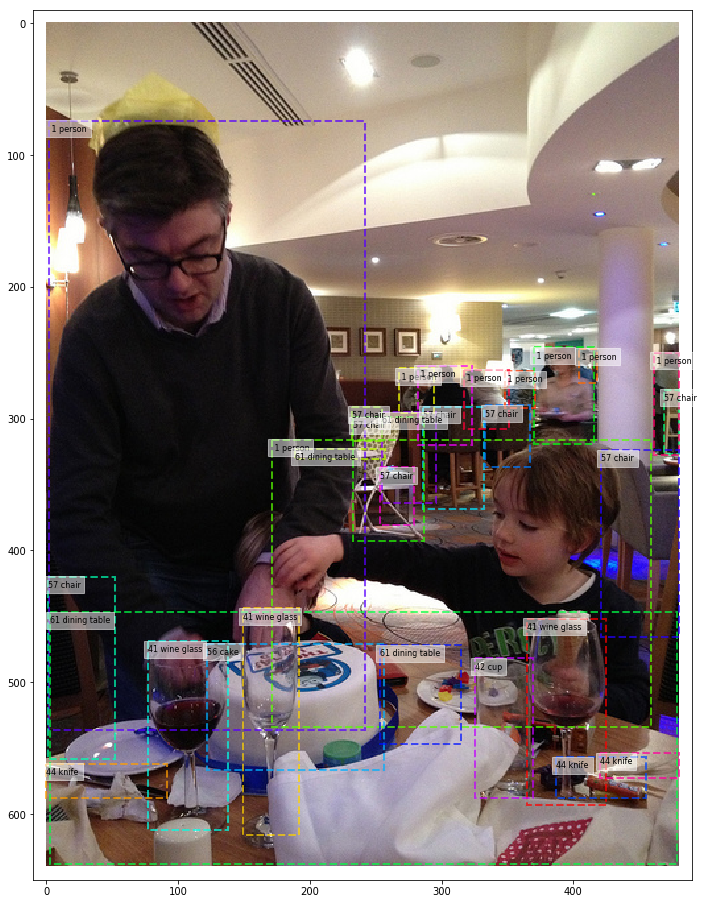

In [18]:
## 62642 (persons),   68539 (trucks) 36466 (surfers)  75040 (boat and persons)
## 36466 surfers. 5498 basketbal players, 27711,30531
## 5498 lots of motorcylces & persons - 
## Persons: #26026, #7719, 111864, 58240,  
## 35347 - laptops, keyboards and cat
## items = [59199 , 102868]
## 89243: Person, bicylce and traiffic lights
## 101623 (cake and forks), 41423 (elephant & people)
## 33477 Table, bowl, cup, sandwich, knife
## 26763 Table, chair, cup , bowl, bottle
## 49316 Table, book, backpack, many bottles
## 12902 Car , truck and traffic light tree
## 57327 person and horses
## 26026 -- mountain, skiers, skiboards 
##  7719 -- people, bottles, handbags
## 27711 -- persons and boats
## 18045 -- person     
## 36769 -- people in meeting room with a 'giraffe'detection?
##  8634 -- person
## 30531 -- tennis players 
##  8645 -- two people
# IMAGE_LIST = [75040] 
# IMAGE_LIST = [89243]
# IMAGE_LIST = [33477]
# IMAGE_LIST = [29731]
# IMAGE_LIST = [26763]
# IMAGE_LIST = [89243]  ## 89243: Person, bicylce and traiffic lights
# IMAGE_LIST = [43168]   ## 43168 Multiple umbrella, chairs, beds
# IMAGE_LIST = [43168]   ## 43168 Multiple umbrella, chairs, beds
IMAGE_LIST= [30531]
IMAGE_LIST = [7]
# IMAGE_LIST = [30533]

train_batch_x = get_training_batch(dataset_train, mrcnn_model.config, IMAGE_LIST)
# train_batch_x, _ =  data_gen_simulate(dataset_train, mrcnn_model.config, [7])
# visualize.display_training_batch(dataset_train, train_batch_x)
# dataset_train.display_annotation_info(IMAGE_LIST)
 

### Display random samples from dataset

#### Display top masks for sample images

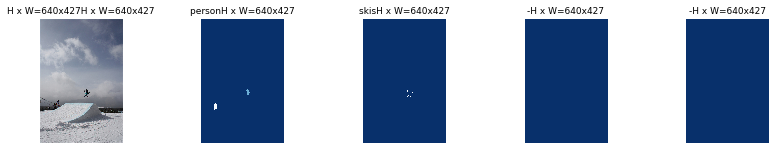

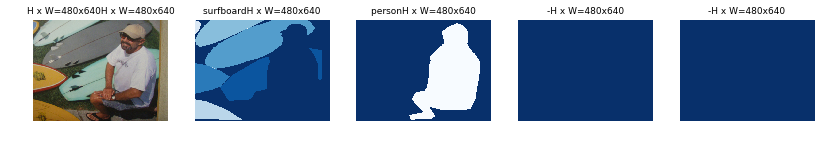

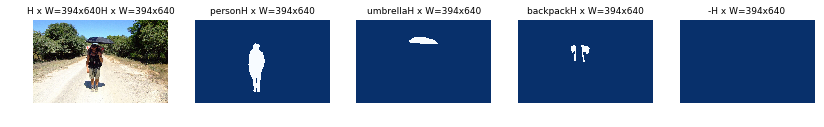

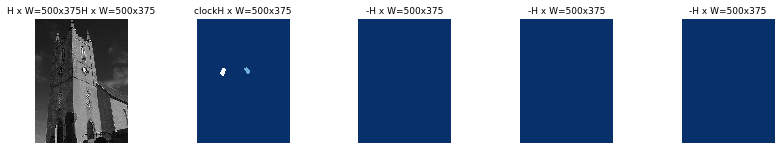

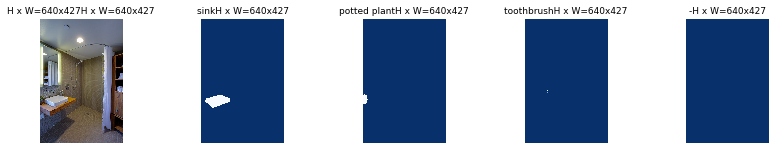

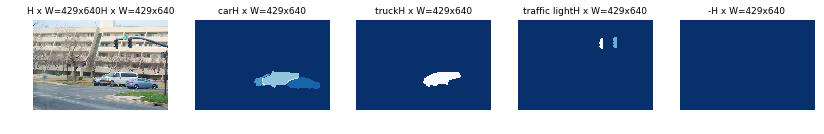

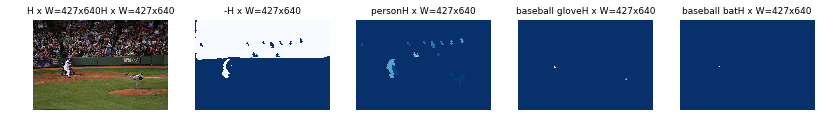

In [9]:
# Load and display random samples
image_ids = np.random.choice(dataset_test.image_ids, 7)
for image_id in image_ids:
    image = dataset_test.load_image(image_id)
    mask, class_ids = dataset_test.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_test.class_names)

####  Dispaly a random image from dataset_test

image_id  17674 http://cocodataset.org/#explore?id=418586
image                    shape: (391, 640, 3)         min:    0.00000  max:  255.00000
mask                     shape: (391, 640, 3)         min:    0.00000  max:    1.00000
class_ids                shape: (3,)                  min:   15.00000  max:   15.00000
bbox                     shape: (3, 4)                min:   95.00000  max:  557.00000
3 3
 display_instances() : Image shape:  (391, 640, 3)


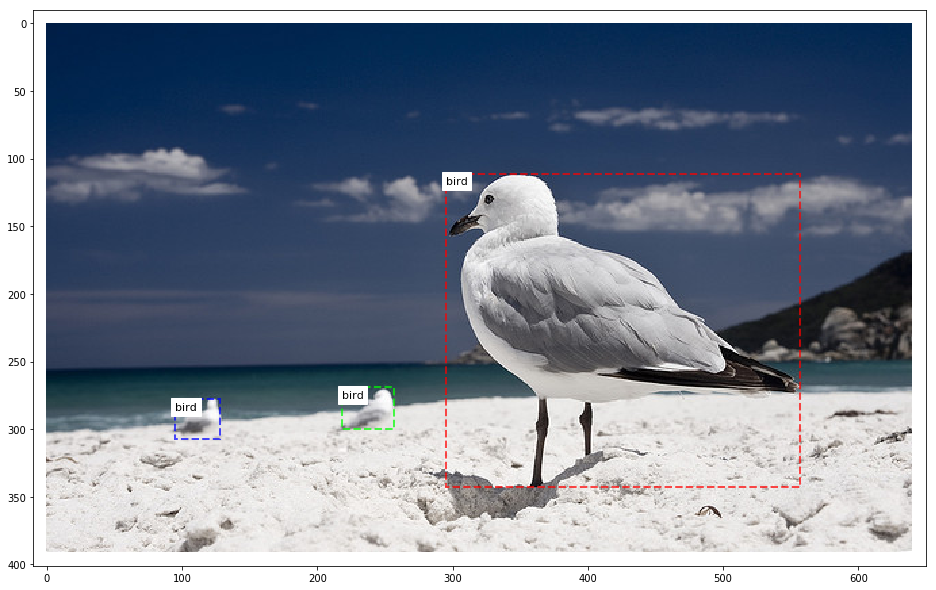

In [10]:
# Load random image and mask. ### 27711 persons and boats
image_id = np.random.choice(dataset_test.image_ids)
image    = dataset_test.load_image(image_id)
mask, class_ids = dataset_test.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset_test.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
print(class_ids.shape[0], bbox.shape[0])
# Display image and instances
# visualize.display_instances_with_mask(image, bbox, mask, class_ids, dataset_train.class_names)
visualize.display_instances(image, bbox, class_ids, dataset_test.class_names)

### Get next image from generator and display 

[20 21 22 23 24 25]
 display_instances() : Image shape:  (427, 640, 3)


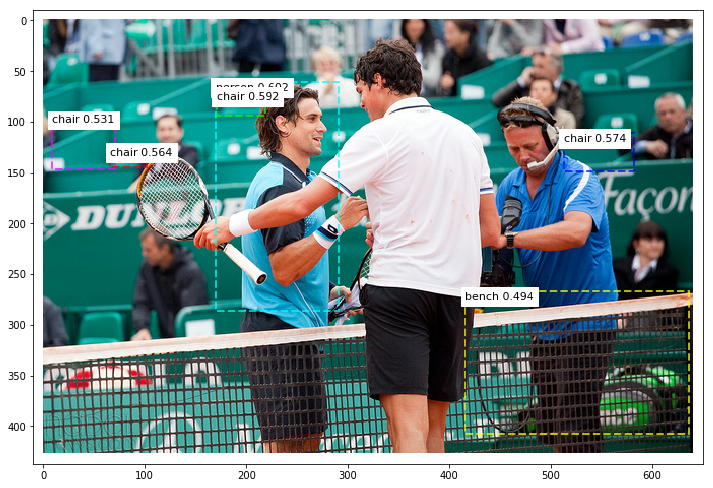

In [22]:
bbox_ixs = np.arange(20,26)
print(bbox_ixs)
# print(r['scores'][bbox_ixs])
visualize.display_instances(image, r['rois'][bbox_ixs], r['class_ids'][bbox_ixs], 
                            dataset_test.class_names, r['scores'][bbox_ixs], ax=visualize.get_ax(size=12))

###  Print some model information 

In [23]:
mrcnn_model.layer_info()



 Inputs:
 -------
 index:  0    input name : input_image:0                              Type: float32           Shape: (?, 1024, 1024, 3)
 index:  1    input name : input_image_meta:0                         Type: float32           Shape: (?, ?)


 Outputs:
 --------
 layer:  0    output name: mrcnn_detection/PyFunc:0                   Type: float32           Shape: <unknown>
 layer:  1    output name: ROI/rpn_roi_proposals:0                    Type: float32           Shape: (1, ?, ?)
 layer:  2    output name: mrcnn_class/Reshape_1:0                    Type: float32           Shape: (?, 1000, 81)
 layer:  3    output name: mrcnn_bbox/Reshape:0                       Type: float32           Shape: (?, 1000, 81, 4)


## Push Data thru model using get_layer_output()

In [42]:
results= run_mrcnn_inference_pipeline(mrcnn_model, dataset_train, train_batch_x, verbose = True)

** Pass through MRCNN model:
/* Inputs */
Input  0:  (input_image:0                           ) 	  Input shape: (1, 1024, 1024, 3)
Input  1:  (input_image_meta:0                      ) 	  Input shape: (1, 89)

Requested layers:
-----------------
Layer   0:  (mrcnn_detection/PyFunc:0                ) 	  Input shape: <unknown>
Layer   1:  (ROI/rpn_roi_proposals:0                 ) 	  Input shape: (1, ?, ?)
Layer   2:  (mrcnn_class/Reshape_1:0                 ) 	  Input shape: (?, 1000, 81)
Layer   3:  (mrcnn_bbox/Reshape:0                    ) 	  Input shape: (?, 1000, 81, 4)
Layer   4:  (cntxt_layer/pred_heatmap:0              ) 	  Input shape: (1, 256, 256, 81)
Layer   5:  (cntxt_layer/pred_heatmap_scores:0       ) 	  Input shape: (1, 81, 200, 23)
    Wrapper for Detection Layer : call()  <class 'list'> 4
      rpn_proposals_roi  : (1, 1000, 4) <class 'numpy.ndarray'>
      mrcnn_class.shape  : (1, 1000, 81) <class 'numpy.ndarray'>
      mrcnn_bboxes.shape : (1, 1000, 81, 4) <class 'nu

#### Load output from pipeline into variables

In [43]:
print(len(results['mrcnn_output']))
# del mrcnn_detection, rpn_roi_proposals, mrcnn_class, mrcnn_bbox
model_mrcnn_detection    = results['mrcnn_output'][0]          # layer:  0   shape: (1, 100, 6)
model_rpn_roi_proposals  = results['mrcnn_output'][1]          # layer:  1   shape: (1, 1000, 4)
model_mrcnn_class        = results['mrcnn_output'][2]          # layer:  2   shape: (1, 1000, 81)
model_mrcnn_bbox         = results['mrcnn_output'][3]          # layer:  3   shape: (1, 1000, 81, 4)
model_pr_hm              = results['mrcnn_output'][4]          # layer:  4   shape: (1, 256, 256, 81)
model_pr_hm_scores       = results['mrcnn_output'][5]          # layer:  5   shape: (1, 81, 100, 11)
# print(type(model_output[4]))
# print(type(output_rois))
for i in results['mrcnn_output']:
    print( i.shape)

6
(1, 200, 6)
(1, 1000, 4)
(1, 1000, 81)
(1, 1000, 81, 4)
(1, 256, 256, 81)
(1, 81, 200, 23)


#### Load input to pipeline in vars

In [ ]:
# del input_image, input_image_meta, input_gt_class_ids, input_gt_bboxes #, input_gt_bboxes_norm
input_image      =  results['mrcnn_input'][0]
input_image_meta =  results['mrcnn_input'][1]
# input_rpn_match      =  train_batch_x[2]
# input_rpn_bbox       =  train_batch_x[3]
# input_gt_class_ids   =  train_batch_x[4]
# input_gt_bboxes      =  train_batch_x[5]

print(' Input image shape is    :', input_image.shape)
print(' Input image_meta        :', type(input_image_meta), input_image_meta.shape)
print(' input_image_meta        :', input_image_meta[0,:10])
# print(' input_rpn_match         :', input_rpn_match.shape)
# print(' input_rpn_bbox          :', input_rpn_bbox.shape)
# print(' input_gt_class_ids      :', input_gt_class_ids.shape)
# print(' input_gt_bboxes         :', input_gt_bboxes.shape)
print(input_image.shape)

h, w = input_image.shape[1], input_image.shape[2]      #  tf.shape(input_image)[1], tf.shape(input_image)[2]
print('height/width', h,w)

#### Display output shapes from `run_pipeline~`

In [49]:
for i in results.keys():
    print(i, type(results[i]))
for i in results['mrcnn_input']:
    print(i.shape)
print('output')
for i in results['mrcnn_output']:
    print(i.shape)    

mrcnn_output <class 'list'>
mrcnn_input <class 'list'>
image_batch <class 'numpy.ndarray'>
(1, 1024, 1024, 3)
(1, 89)
(1, 261888, 1)
(1, 256, 4)
(1, 100)
(1, 100, 4)
output
(1, 100, 6)
(1, 1000, 4)
(1, 1000, 81)
(1, 1000, 81, 4)
(1, 256, 256, 81)
(1, 81, 100, 23)


#### display outputs

In [282]:
print(model_mrcnn_detection.shape)
print(model_mrcnn_detection)
# print('mrcnn_class shape:', mrcnn_class.shape)
# print('mrcnn_bbox shape :', mrcnn_bbox.shape)
# pred_scores  = np.max(mrcnn_class,axis = -1)
# pred_classes = np.argmax(mrcnn_class,axis = -1)
# # pred_classes_2 = np.take(out_mrcnn_bbox, pred_classes, axis = 2)  
# print(pred_classes.shape)
# print(pred_classes[0])

# print(mrcnn_bbox[0,0])
# pred_bboxes  = mrcnn_bbox[:, pred_classes]
# print('pred_scores shape:', pred_scores.shape)
# print('pred_classes shape:', pred_classes.shape)
# print('pred_bboxes shape:', pred_scores.shape)
# print(mrcnn_bbox.shape)
# print(pred_bboxes.shape)
# print(pred_bboxes[0,:10])


# print(' pred_scores \n',pred_scores)
# print(' pred_classes \n', pred_classes)
# for cls,score in zip(pred_classes,pred_scores):
#     print(' {:3d} {:.<20s} {:4f} '.format(cls, class_names[cls],score))


# print(input_gt_boxes.shape, input_image.shape)
# print('output_rois',model_rpn_roi_proposals.shape, 'deltas ', model_mrcnn_bbox.shape, 'class_ids ', model_mrcnn_class.shape)
# print(model_rpn_roi_proposals[0,:20])
# print(model_rpn_roi_proposals[0,:20]*[h,w,h,w])
# print(input_gt_class_ids)
# print(input_normlzd_gt_bboxes)
# print(input_gt_bboxes_norm.shape)
# print(rpn_roi_proposals.shape)

(1, 100, 6)
[[[  92.000  145.000  890.000  505.000    1.000    0.996]
  [ 390.000  721.000  492.000  799.000    1.000    0.993]
  [ 424.000  685.000  466.000  724.000    1.000    0.990]
  [ 418.000  634.000  489.000  685.000    1.000    0.986]
  [ 419.000  556.000  471.000  594.000    1.000    0.984]
  [ 739.000  231.000 1021.000  885.000   61.000    0.984]
  [ 749.000  249.000  984.000  350.000   41.000    0.977]
  [ 731.000  712.000  937.000  807.000   41.000    0.957]
  [ 419.000  581.000  510.000  646.000    1.000    0.954]
  [ 476.000  495.000  633.000  560.000   57.000    0.949]
  [ 705.000  362.000  929.000  437.000   41.000    0.927]
  [ 466.000  497.000  501.000  536.000   57.000    0.909]
  [ 761.000  652.000  945.000  731.000   41.000    0.868]
  [ 671.000  131.000  885.000  208.000   57.000    0.846]
  [ 506.000  429.000  798.000  875.000    1.000    0.811]
  [ 463.000  656.000  550.000  716.000   57.000    0.803]
  [ 462.000  591.000  590.000  658.000   57.000    0.789]
  

## simulation of mrcnn model `Detect()` routine

###  `unmold_detections()`

In [9]:
def unmold_detections(self, detections, image_shape, window):
    '''
    Reformats the detections of one image from the format of the neural
    network output to a format suitable for use in the rest of the application.

    Input:
    --------
    detections  : [N, (y1, x1, y2, x2, class_id, score)]
    mrcnn_mask  : [N, height, width, num_classes]
    image_shape : [height, width, depth] Original size of the image before resizing
    window      : [y1, x1, y2, x2] Box in the image where the real image is
                   (i.e.,  excluding the padding surrounding the real image)

    Returns:
    --------
    boxes       : [N, (y1, x1, y2, x2)] Bounding boxes in pixels
    class_ids   : [N] Integer class IDs for each bounding box
    scores      : [N] Float probability scores of the class_id
    --- masks       : [height, width, num_instances] Instance masks
    '''

    # print('>>>  unmold_detections ')
    # print('     detections.shape : ', detections.shape)
    # print('     mrcnn_mask.shape : ', mrcnn_mask.shape)
    # print('     image_shape.shape: ', image_shape)
    # print('     window.shape     : ', window)
    # print(detections)

    ##-----------------------------------------------------------------------------------------
    ## How many detections do we have?
    ##  Detections array is padded with zeros. detections[:,4] identifies the class 
    ##  Find all rows in detection array with class_id == 0 , and place their row indices
    ##  into zero_ix. zero_ix[0] will identify the first row with class_id == 0.
    ##-----------------------------------------------------------------------------------------
    print()
    np.set_printoptions(linewidth=100)        

    zero_ix = np.where(detections[:, 4] == 0)[0]

    N = zero_ix[0] if zero_ix.shape[0] > 0 else detections.shape[0]

    # print(' np.where() \n', np.where(detections[:, 4] == 0))
    # print('     zero_ix.shape     : ', zero_ix.shape)
    # print('     N is :', N)

    ##-----------------------------------------------------------------------------------------
    ## Extract boxes, class_ids, scores, and class-specific masks
    ##-----------------------------------------------------------------------------------------
    boxes     = detections[:N, :4]
    class_ids = detections[:N, 4].astype(np.int32)
    scores    = detections[:N, 5]
    # masks     = mrcnn_mask[np.arange(N), :, :, class_ids]

    ##-----------------------------------------------------------------------------------------
    ## Compute scale and shift to translate coordinates to image domain.
    ##-----------------------------------------------------------------------------------------
    h_scale = image_shape[0] / (window[2] - window[0])
    w_scale = image_shape[1] / (window[3] - window[1])
    scale   = min(h_scale, w_scale)
    shift   = window[:2]  # y, x
    scales = np.array([scale, scale, scale, scale])
    shifts = np.array([shift[0], shift[1], shift[0], shift[1]])

    ##-----------------------------------------------------------------------------------------
    ## Translate bounding boxes to image domain
    ##-----------------------------------------------------------------------------------------
    boxes = np.multiply(boxes - shifts, scales).astype(np.int32)

    ##-----------------------------------------------------------------------------------------
    ## Filter out detections with zero area. Often only happens in early
    ## stages of training when the network weights are still a bit random.
    ##-----------------------------------------------------------------------------------------
    exclude_ix = np.where(
        (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]) <= 0)[0]

    if exclude_ix.shape[0] > 0:
        boxes     = np.delete(boxes, exclude_ix, axis=0)
        class_ids = np.delete(class_ids, exclude_ix, axis=0)
        scores    = np.delete(scores, exclude_ix, axis=0)
        N         = class_ids.shape[0]

    return boxes, class_ids, scores     # , full_masks

### `detect()`  - Prepare image to pass to model prediction

Processing 1 images
image                    shape: (426, 640, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000
 Image_id    :  1  Reference:  http://cocodataset.org/#explore?id=524291 Coco Id: 524291
 Image meta [   1  426  640    3  171    0  853 1024    0    0]
 Class ids   :  (4,)    [17 17  1 30]
 Class Names :  ['dog', 'dog', 'person', 'frisbee']


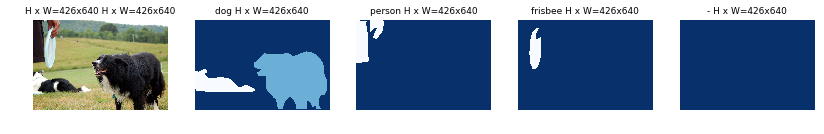

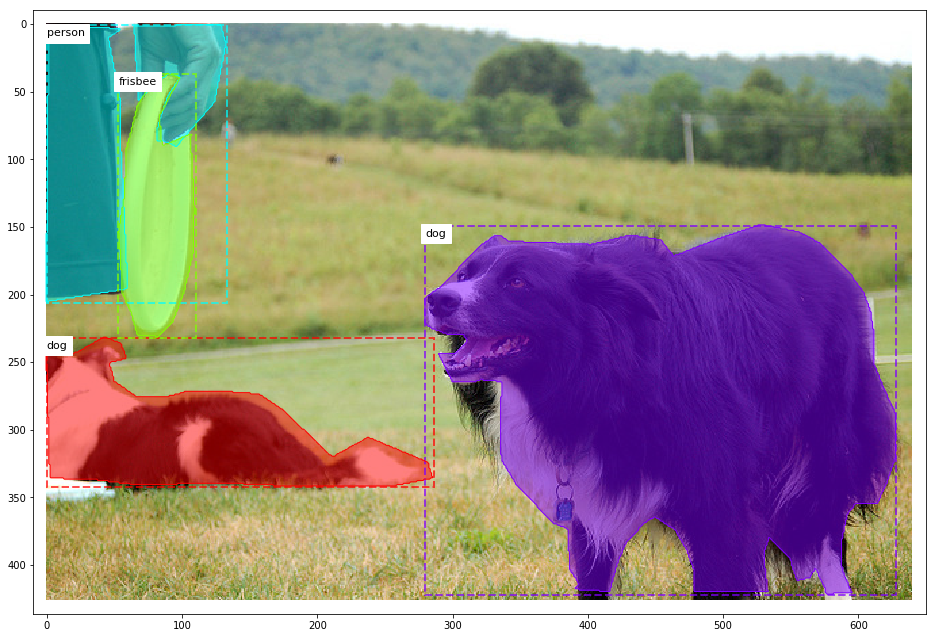

In [44]:
images, _ = get_inference_batch(dataset_train,mrcnn_model, 1, display=True)


In [45]:
#     def detect(self, images, verbose=0):
'''
Runs the detection pipeline.

images:         List of images, potentially of different sizes.

Returns a list of dicts, one dict per image. The dict contains:

rois:           [N, (y1, x1, y2, x2)] detection bounding boxes
class_ids:      [N] int class IDs
scores:         [N] float probability scores for the class IDs
masks:          [H, W, N] instance binary masks
'''

assert mrcnn_model.mode   == "inference", "Create model in inference mode."
assert len(images) == mrcnn_model.config.BATCH_SIZE, "len(images): {:3d} must be equal to BATCH_SIZE: {:3d}".format(len(images),self.config.BATCH_SIZE)

if verbose:
    log("Processing {} images".format(len(images)))
    for image in images:
        log("image", image)

# Mold inputs to format expected by the neural network
molded_images, image_metas, windows = mrcnn_model.mold_inputs(images)

if verbose:
    log("molded_images", molded_images)
    log("image_metas"  , image_metas)


Processing 1 images
image                    shape: (426, 640, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000


### `Detect( )` pass image to `mrcnn_model.predict()`

In [72]:
## Run object detection pipeline
# print('    call predict()')
detections, rpn_roi_proposals, mrcnn_class, mrcnn_bbox, pr_hm, pr_scores_by_class =  \
          mrcnn_model.keras_model.predict([molded_images, image_metas], verbose=0)

    Wrapper for Detection Layer : call()  <class 'list'> 4
      rpn_proposals_roi  : (1, 1000, 4) <class 'numpy.ndarray'>
      mrcnn_class.shape  : (1, 1000, 81) <class 'numpy.ndarray'>
      mrcnn_bboxes.shape : (1, 1000, 81, 4) <class 'numpy.ndarray'>
      image_meta         : (1, 89) <class 'numpy.ndarray'>


 config.DETECTION_MAX_INSTANCES:  200
 Detections shape: (9, 6)


In [73]:
print('Return from  predict()')
print('    Length of detections : ', len(detections))
# print('    detections \n', detections)
print('    Length of rpn_roi_proposals   : ', len(rpn_roi_proposals   ))
# print('    Length of rpn_class  : ', len(rpn_class  ))
# print('    Length of rpn_bbox   : ', len(rpn_bbox   ))
print('    Length of mrcnn_class  : ',   mrcnn_class.shape)
print('    Length of mrcnn_bbox   : ',   mrcnn_bbox.shape)
print('    Length of pr_hm        : ',   pr_hm.shape)
print('    Length of pr_hm_scores_by_class : ',   pr_scores_by_class.shape)


Return from  predict()
    Length of detections :  1
    Length of rpn_roi_proposals   :  1
    Length of mrcnn_class  :  (1, 1000, 81)
    Length of mrcnn_bbox   :  (1, 1000, 81, 4)
    Length of pr_hm        :  (1, 256, 256, 81)
    Length of pr_hm_scores_by_class :  (1, 81, 200, 23)


### `detect( )` -  call `unmold_detections()` - Prepare output of model prediction for display

In [80]:
## Process detections
results = []
for i, image in enumerate(images):

    # final_rois, final_class_ids, final_scores, \
    # final_pre_scores, final_fcn_scores          \
    # =  self.unmold_detections_new(fcn_hm_scores[i],  detections[i], image.shape, windows[i])    
    final_rois, final_class_ids, final_scores, molded_rois = mrcnn_model.unmold_detections(detections[i], 
                                                                       image.shape  ,
                                                                       windows[i])    

    ## reshape pr_scores from pre_class to per_image
    ## pr_hm_scores is by image/class
    ## Convert pr_hm_scores bboxes from NN coordinates to image coordinates
    pr_boxes_adj = utils.boxes_to_image_domain(pr_scores_by_class[i,:,:,:4],image_metas[i])
    pr_scores_by_class_adj= np.dstack((pr_boxes_adj, pr_scores_by_class[i,:,:,4:]))  
#     print('pr_scores_by_class    ', pr_scores_by_class.shape)
    pr_scores_by_image = utils.byclass_to_byimage_np(pr_scores_by_class_adj, 6)

    np.set_printoptions(linewidth=180,precision=4,threshold=10000, suppress = True)
#     print(' pr_scores_by_class shape:', pr_scores_by_class.shape)
    print(' molded_rois:', molded_rois.shape)
    print(molded_rois)    
    print(' final_rois:', final_rois.shape)
    print(final_rois)
    print(' pr_scores_by_class_adj', pr_scores_by_class_adj.shape)
    print(' pr_scores_by_image:', pr_scores_by_image.shape)
    print(pr_scores_by_image[...,:6])


    results.append({
        "image"        : images[i],
        "molded_image" : molded_images[i], 
        "image_meta"   : image_metas[i],

        "rois"         : final_rois,
        "molded_rois"  : molded_rois,
        "class_ids"    : final_class_ids,
        "scores"       : final_scores,

        "pr_scores"    : pr_scores_by_image,
        "pr_scores_by_class"    : pr_scores_by_class_adj,
        "pr_hm"        : pr_hm,

    })


 molded_rois: (9, 4)
[[ 431.  441.  831. 1024.]
 [ 224.   86.  543.  168.]
 [ 539.    0.  728.  435.]
 [ 277.  205.  324.  225.]
 [ 171.    0.  501.  205.]
 [ 171.    2.  499.  156.]
 [ 178.    4.  520.  194.]
 [ 185.   14.  507.  187.]
 [ 171.   19.  525.  183.]]
 final_rois: (9, 4)
[[162 275 412 639]
 [ 33  53 232 104]
 [229   0 347 271]
 [ 66 128  95 140]
 [  0   0 206 128]
 [  0   1 204  97]
 [  4   2 217 121]
 [  8   8 209 116]
 [  0  11 221 114]]
 pr_scores_by_class_adj (81, 200, 23)
 pr_scores_by_image: (9, 23)
[[162.     275.     412.     639.      17.       0.9856]
 [ 33.      53.     232.     104.      30.       0.9429]
 [229.       0.     347.     271.      17.       0.9328]
 [ 66.     128.      95.     140.       1.       0.9325]
 [  0.       0.     206.     128.       1.       0.8075]
 [  0.       1.     204.      97.      27.       0.6881]
 [  4.       2.     217.     121.      36.       0.374 ]
 [  8.       8.     209.     116.      39.       0.3623]
 [  0.      11.    

### Display results

In [97]:
float_formatter = lambda x: "%9.4f" % x
np_format = {}
np_format['float']=float_formatter
np.set_printoptions(linewidth=195, precision=3, floatmode='fixed', threshold =10000, formatter = np_format)
# np.set_printoptions(linewidth=180,precision=4,threshold=10000, suppress = True)
r = results[0]

print('  rois           : ', r['rois'].shape)
print('  class ids      : ', r['class_ids'].shape)
print('  scores         : ', r['scores'].shape)
# print('  rois - classids -scores stacked: ')
# print(np.hstack((r['rois'],r['class_ids'], r['scores'])) )
print('  pr_heatmap     : ', r['pr_hm'].shape)
# print('  pr_hm_scores  : ', r['pr_hm_scores'].shape)
# print('  pr_scores  : ')
# print(r['pr_hm_scores'][0,1,:20])

## reshape pr_scores from pre_class to per_image
# pr_scrs = utils.byclass_to_byimage_np(r['pr_hm_scores'][0],6)
# print('  pr_scrs    : ', pr_scrs.shape)
# print('  pr_scrs    : ')
# print(pr_scrs[:40])

## Convert pr_scores from NN coordinates to image coordinates
# pr_scr_boxes = utils.boxes_to_image_domain(pr_scrs[:,:4],image_metas[0])
# print('  pr_scrs    : ', pr_scrs.shape)
# print('  pr_scr_boxes: ', pr_scr_boxes.shape)
# print('  pr_scr_boxes: ')
# print(pr_scr_boxes)

## final pr_scores_adj
# print(np.hstack((pr_scr_boxes, pr_scrs[:,4:])))
print('  pr_scores  : ', r['pr_scores'].shape)
# print('  pr_scores  : ')
# print(r['pr_scores'][:,4:])

for i in range(r['pr_scores'].shape[0]):
    print(r['pr_scores'][i,[4,5,7,8,10]],r['pr_scores'][i,11:17],r['pr_scores'][i,17:23] )

  rois           :  (9, 4)
  class ids      :  (9,)
  scores         :  (9,)
  pr_heatmap     :  (1, 256, 256, 81)
  pr_scores  :  (9, 23)
[  17.0000    0.9856    1.0000    1.0000    1.0000] [ 190.2749  270.0000    0.7047    1.0000    1.0000    1.0000] [ 190.2749  270.0000    0.7047    1.0000    1.0000    1.0000]
[  30.0000    0.9429    1.0000    0.9987    0.9987] [  63.0610   91.0000    0.6930    1.0000    1.0000    1.0000] [  63.0610   91.0000    0.6930    1.0000    1.0000    1.0000]
[  17.0000    0.9328    0.9465    1.0000    0.9465] [ 101.9168  150.0000    0.6794    0.5356    0.5556    0.9641] [ 101.9168  150.0000    0.6794    0.5356    0.5556    0.9641]
[   1.0000    0.9325    1.0000    0.8382    0.8382] [  12.6348   20.0000    0.6317    0.1449    0.1399    1.0000] [  12.6348   20.0000    0.6317    0.1449    0.1399    1.0000]
[   1.0000    0.8075    0.8659    1.0000    0.8659] [  87.2232  143.0000    0.6100    1.0000    1.0000    0.9655] [  87.2232  143.0000    0.6100    1.0000   

In [52]:
class_names = dataset_train.class_names

(9,)
 display_instances() : Image shape:  (426, 640, 3)


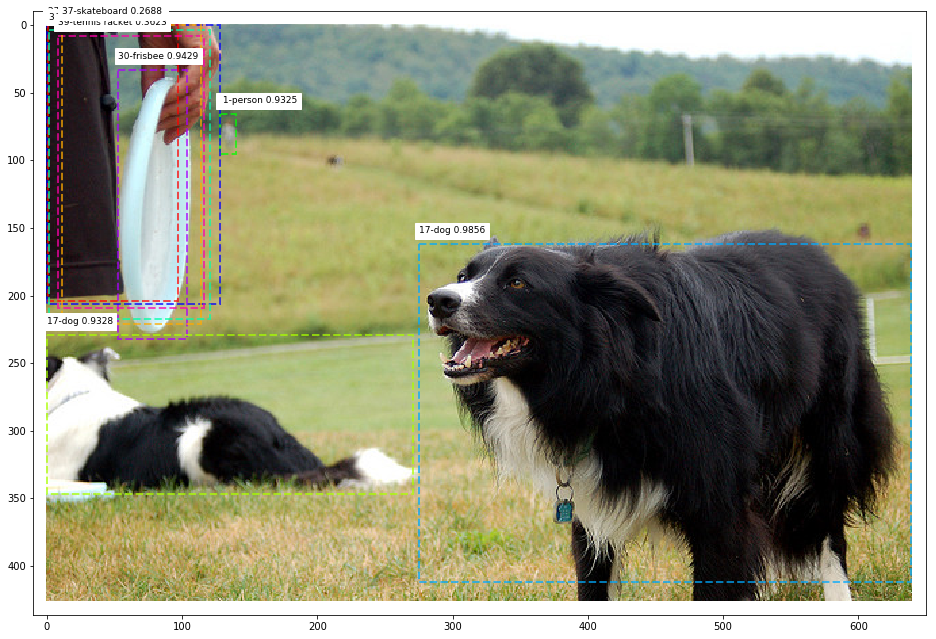

In [81]:
print(r['scores'].shape)
r = results[0]
# visualize.display_instances(image, r['rois'], r['class_ids'], class_names, r['scores'])
visualize.display_instances_from_prscores(image, r['pr_scores'], class_names)

Image shape : (1024, 1024, 3)  class_ids: [ 1  2  4 18 25 75]
heatmaps shape: (256, 256, 81) bboxes shape : (81, 100, 4)
1- image    :  (1024, 1024, 3) float64 -123.7 151.1
2- image    :  (1024, 1024, 3) uint8 0 255


D:\Program Files\Anaconda3\envs\TF\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
D:\Program Files\Anaconda3\envs\TF\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
D:\Program Files\Anaconda3\envs\TF\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


3- image    :  (428, 640, 3) uint8 0 255
5- image_bw:  (428, 640) uint8 10 255


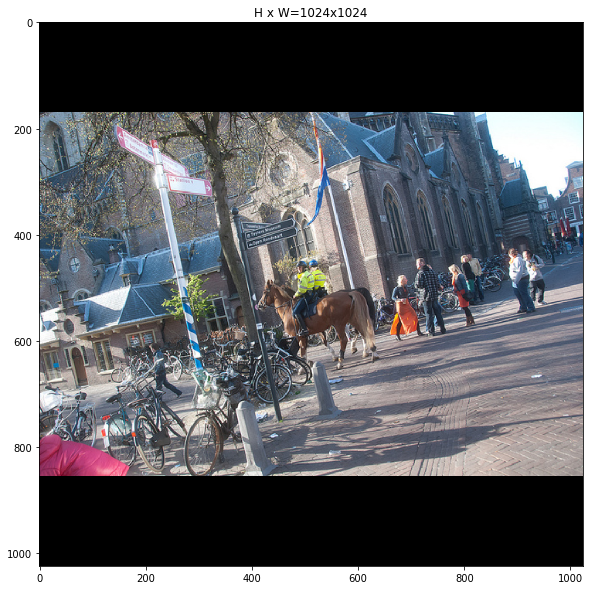

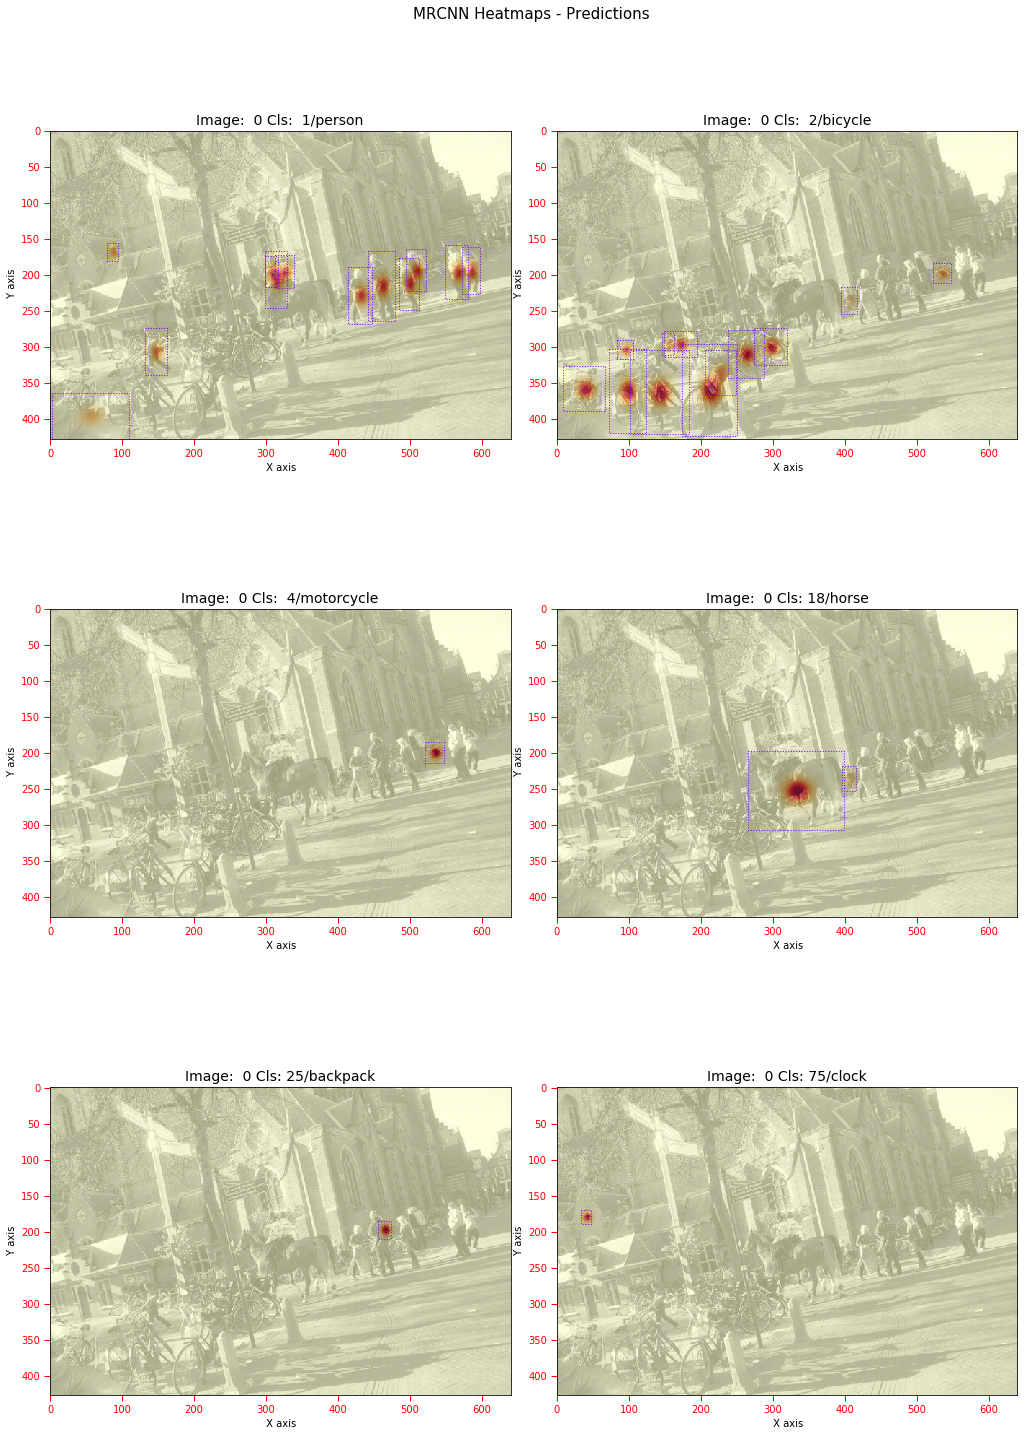

In [146]:
from mrcnn.visualize import display_heatmaps_mrcnn
# np.unique(r['class_ids'])
display_heatmaps_mrcnn([molded_images, image_metas], [r['pr_hm'], r['pr_hm_scores']], 0, class_ids = r['class_ids'], 
                            class_names = class_names, config = mrcnn_config)


## Display Heatmaps

In [285]:
img_id = 0
print('Image id: ',image_id, ' Coco ID: ', dataset_train.image_info[image_id]['id'])
# gt_class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
pr_class_ids = np.unique(model_pr_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
# print('Image : {}  Ground Truth ClassIds: {}'.format(img_id, gt_class_ids))
print('Image : {}  Predicted    ClassIds: {}'.format(img_id, pr_class_ids))

Image id:  7  Coco ID:  393251
Image : 0  Predicted    ClassIds: [0, 1, 41, 42, 44, 45, 56, 57, 61]


### 2D Plots  

####  2D plot of `model_gt_heatmap` returned from model

 Image Id:  0  Display classes: [0, 1, 41, 42, 44, 45, 56, 57, 61]
 rows   3  columns : 3 boxes.shape :  (81, 100, 23)
 min_z_all shape: ()  min_z_all: 0.0  max_z_all: () max_z_all: 1.0
 min_z_cls shape: (1, 1, 81)  max_z_cls shape: (1, 1, 81)
 SCALING == all


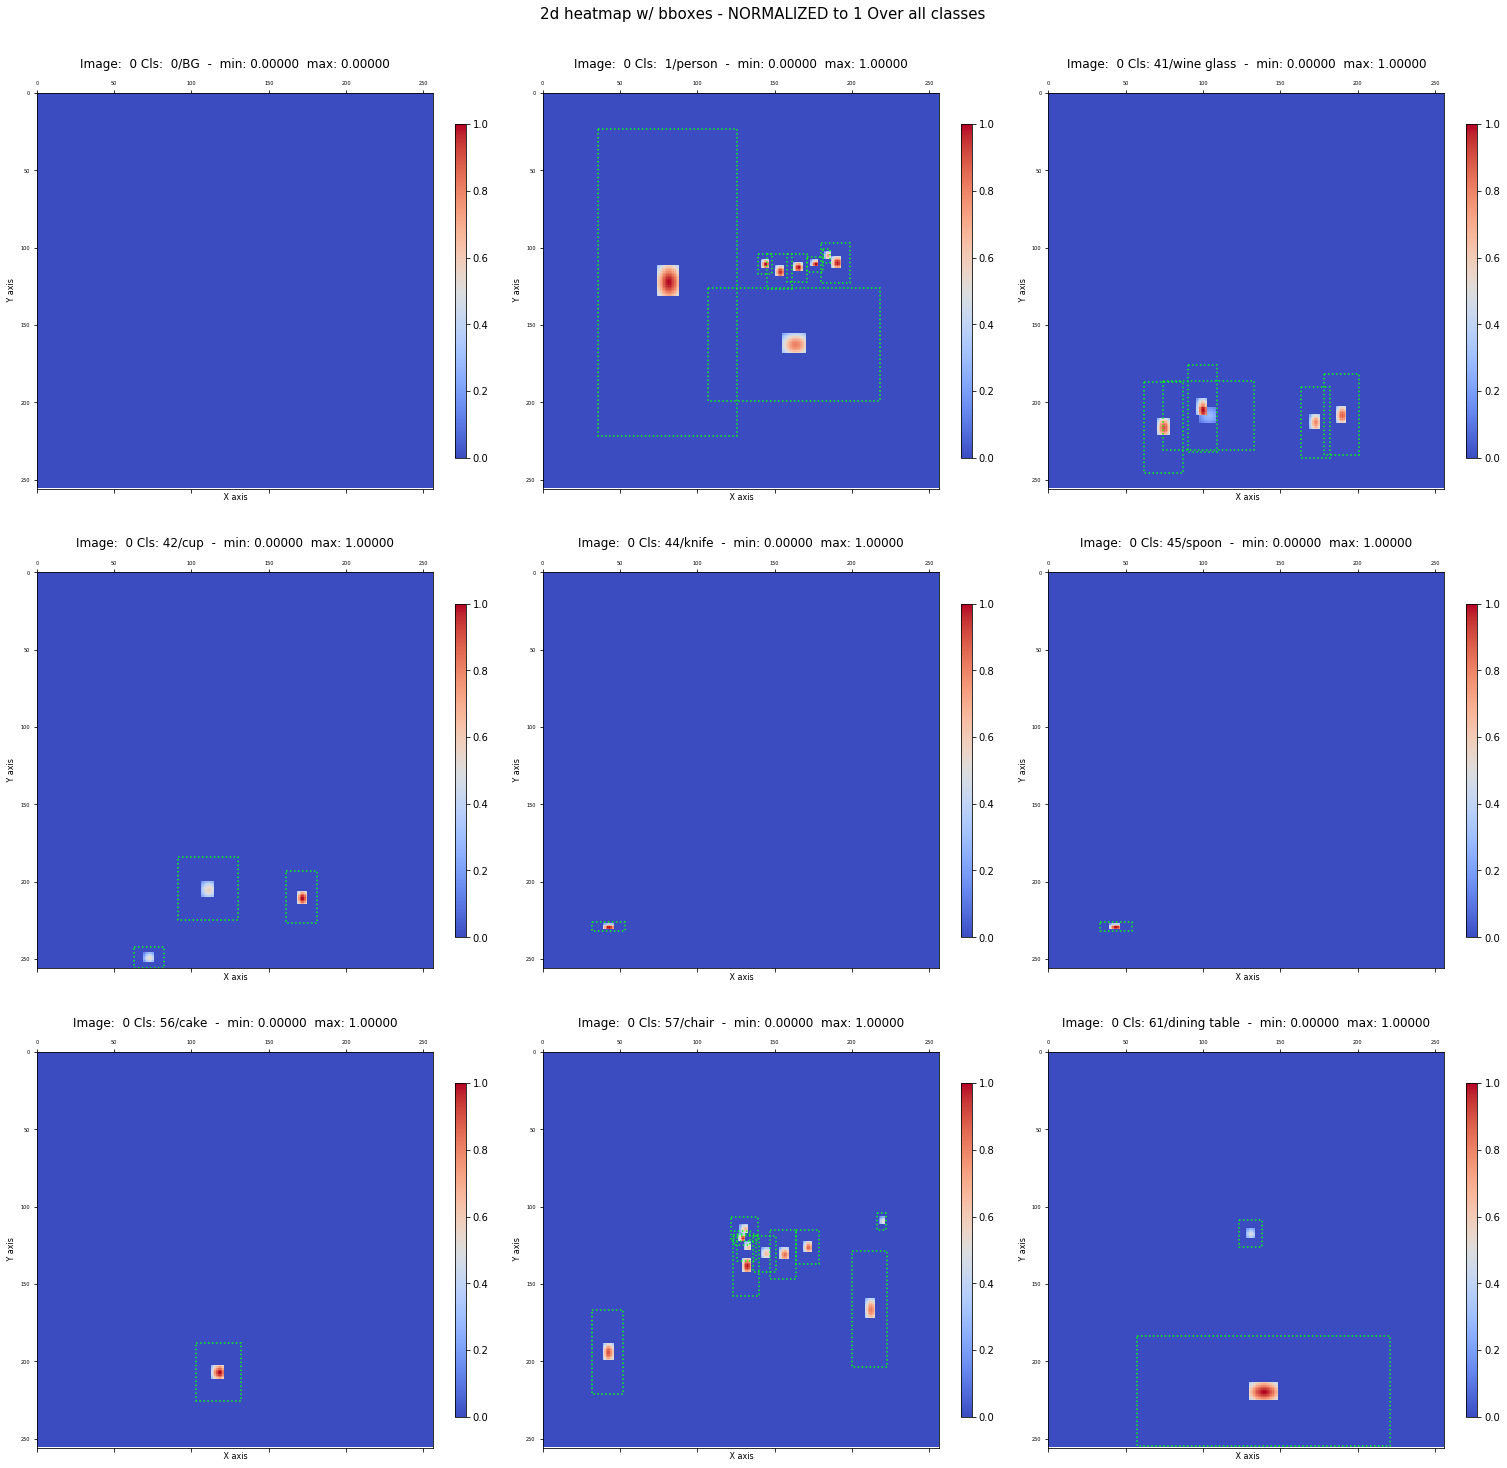

In [292]:
img_id = 0
fig = visualize.plot_2d_heatmap(model_pr_hm , model_pr_hm_scores, img_id, pr_class_ids, 
                          class_names = class_names, columns = 3, scale = 4, scaling = 'all')

####  2D plot of `model_fcn_heatmap` returned from model - ALL CLASSES

In [294]:
# fig = visualize.plot_2d_heatmap(model_pr_hm, model_pr_hm_scores, img_id,
#                                 class_names = class_names, columns = 3, scale = 4, scaling = 'all')

Image : 0  ClassIds: [0, 1, 41, 42, 44, 45, 56, 57, 61]
 Scaling options are 'all', 'class', or 'clip'/ None 
Display classes: [0, 1, 41, 42, 44, 45, 56, 57, 61]
rows   5  columns : 2
4
 min_z_all shape: ()  min_z_all: 0.0  max_z_all: () max_z_all: 1.0
 min_z_cls shape: (1, 1, 81)  max_z_cls shape: (1, 1, 81)
 SCALING == none 
1 zlim = each  zlim_min : 0.00000000 zlim_max: 0.00000000 


D:\Program Files\Anaconda3\envs\TF\lib\site-packages\mpl_toolkits\mplot3d\axes3d.py:744: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


1 zlim = each  zlim_min : 0.00000000 zlim_max: 1.00000000 
1 zlim = each  zlim_min : 0.00000000 zlim_max: 1.00000000 
1 zlim = each  zlim_min : 0.00000000 zlim_max: 1.00000000 
1 zlim = each  zlim_min : 0.00000000 zlim_max: 1.00000000 
1 zlim = each  zlim_min : 0.00000000 zlim_max: 1.00000000 
1 zlim = each  zlim_min : 0.00000000 zlim_max: 1.00000000 
1 zlim = each  zlim_min : 0.00000000 zlim_max: 1.00000000 
1 zlim = each  zlim_min : 0.00000000 zlim_max: 1.00000000 


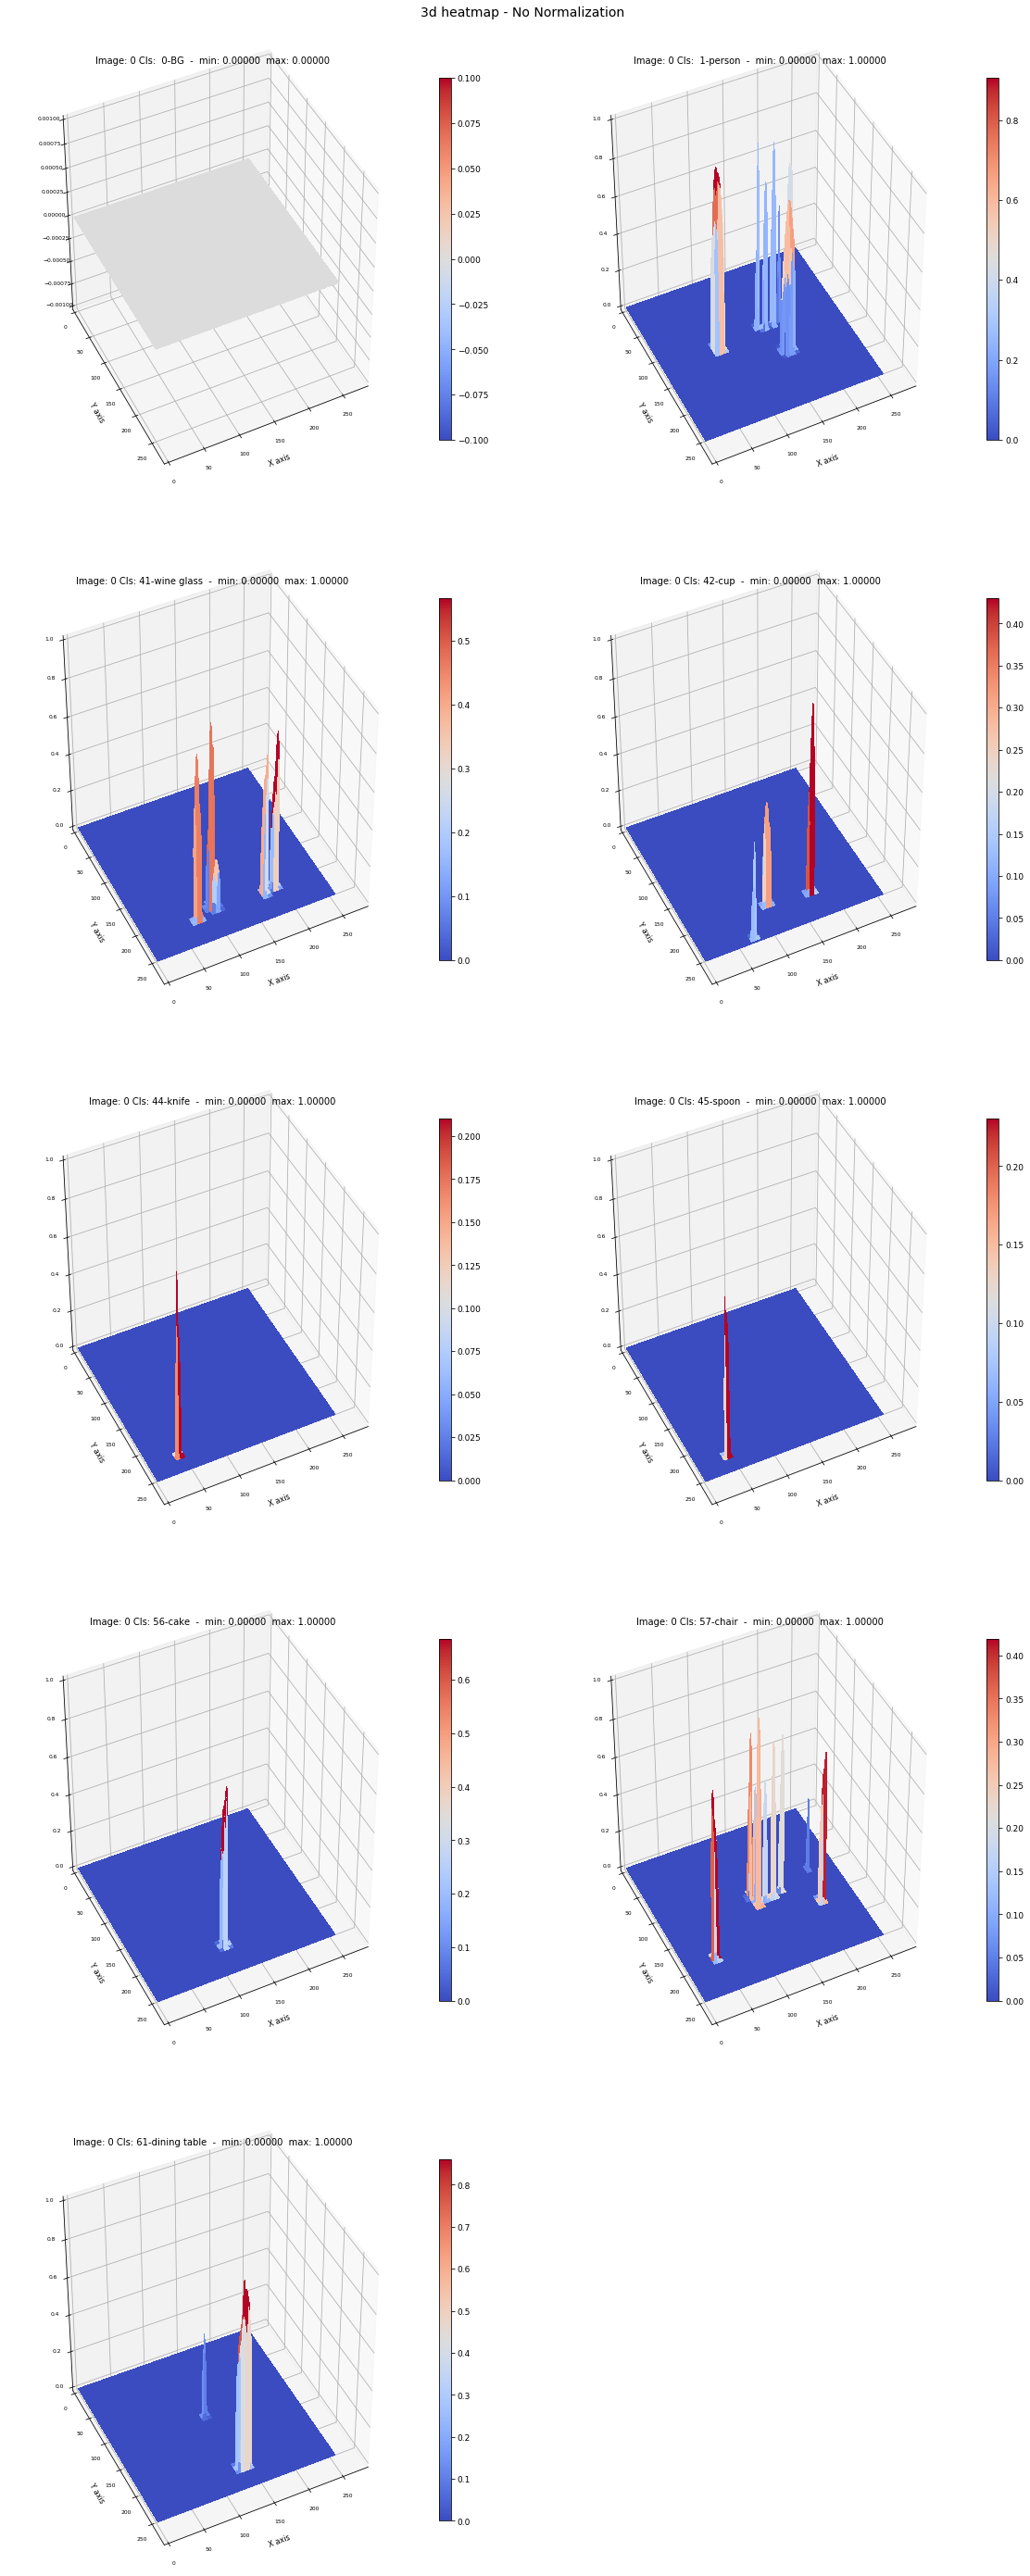

In [297]:
print('Image : {}  ClassIds: {}'.format(img_id, pr_class_ids))
visualize.plot_3d_heatmap(model_pr_hm, img_id, pr_class_ids, class_names = class_names, zlim = 'class' , scaling = 'none')